<a href="https://colab.research.google.com/github/mralamdari/NLP-Text_Classification/blob/main/NLP_Text_Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import nltk
import string
import sklearn
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

from sklearn import svm
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import feature_extraction
from sklearn import model_selection

In [2]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH
data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2022-05-27 05:31:38--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.06s   

2022-05-27 05:31:39 (192 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K May 27 05:31 .
drwxr-xr-x 1 root root 4.0K May 27 05:31 ..
-rw-r--r-- 1 root root  12M May 27 05:31 Full-Economic-News-DFE-839861.csv


In [3]:
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.6400,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.0000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.0000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.6750,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.6400,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,830985632,False,finalized,3,11/17/15 18:16,7.0,0.3511,yes,0.6641,wapo_152454634,2/11/52,"Sawyer Sees Strong Economy For 2 Years, Truce ...",NaN,NaN,Secretary of Commerce Charles W. Sawyer said y...
7996,830985633,False,finalized,3,11/18/15 8:10,NaN,NaN,no,1.0000,wapo_410349039,12/13/09,Oil's losses are airlines' gains,NaN,NaN,"U.S. stocks inched up last week, overcoming co..."
7997,830985634,False,finalized,3,11/18/15 12:12,NaN,NaN,no,1.0000,wapo_410346237,12/18/09,Full Senate to vote on Bernanke; PANEL ADVANCE...,NaN,NaN,Ben S. Bernanke cleared a key hurdle Thursday ...
7998,830985635,False,finalized,3,11/18/15 7:17,NaN,0.0000,no,0.6855,wapo_307808606,1/10/95,Reinventing Opportunities,NaN,NaN,The White House's push to contract out many fe...


In [4]:
data.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance',
       'relevance:confidence', 'articleid', 'date', 'headline',
       'positivity_gold', 'relevance_gold', 'text'],
      dtype='object')

In [5]:
data.shape

(8000, 15)

In [6]:
100*data.relevance.value_counts() / data.shape[0]

no          82.1375
yes         17.7500
not sure     0.1125
Name: relevance, dtype: float64

In [7]:
data.relevance.value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [8]:
#remove 'not sure' from dataset (it is just 9 data)
data = data[data.relevance != 'not sure']

In [9]:
data['relevance'] = data.relevance.map({'yes': 1, 'no': 0})
data = data[['text', 'relevance']]

In [10]:
data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [11]:
stopwords = sklearn.feature_extraction._stop_words.ENGLISH_STOP_WORDS
def data_processing(doc):
  doc = doc.replace('</br>', ' ')
  doc = ''.join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = ' '.join([token for token in doc.split() if token not in stopwords])
  return doc

In [15]:
x = data.text
y = data.relevance
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=23, test_size=0.25)

In [16]:
print(x_train.shape, y_train.shape)

(5993,) (5993,)


In [17]:
print(x_test.shape, y_test.shape)

(1998,) (1998,)


In [23]:
vect = feature_extraction.text.CountVectorizer(preprocessor=data_processing)

x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)

print(x_train_dtm.shape, x_test_dtm.shape)

(5993, 49755) (1998, 49755)


In [36]:
print(len(vect.get_feature_names_out()))
vect.get_feature_names_out()

49755


array(['AA', 'AAA', 'AACER', ..., 'åÈi', 'åÈn', 'åÈut'], dtype=object)

In [37]:
print(len(vect.get_feature_names()))
vect.get_feature_names()[20:40]

49755


['ABU',
 'ABkLtFI',
 'ABkTPa',
 'ABkrFla',
 'AC',
 'ACAPULCO',
 'ACCB',
 'ACLU',
 'ACORN',
 'ACQUIRES',
 'ACS',
 'ACSs',
 'ACTUAL',
 'ACoLl',
 'ACtyBk',
 'AD',
 'ADA',
 'ADC',
 'ADD',
 'ADEAR']

In [39]:
naive_bayes_model = naive_bayes.MultinomialNB()
naive_bayes_model.fit(x_train_dtm, y_train)
naive_bayes_predict = naive_bayes_model.predict(x_test_dtm)

In [43]:
100 * metrics.accuracy_score(y_test, naive_bayes_predict)

77.92792792792793

In [51]:
def confusion_mat(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label', fontsize=15)
  plt.xlabel('Predicted Label', fontsize=15)

Accuracy:  0.7792792792792793
ROC AUC Score:  0.6324957693920941


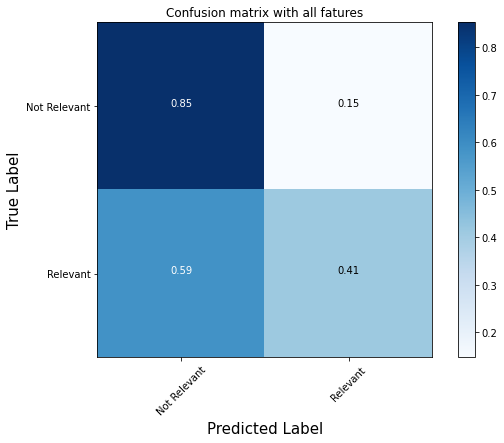

In [55]:
print('Accuracy: ', metrics.accuracy_score(y_test, naive_bayes_predict))

cnf_matrix = metrics.confusion_matrix(y_test, naive_bayes_predict)
plt.figure(figsize=(8, 6))
confusion_mat(cnf_matrix, classes=['Not Relevant', 'Relevant'],
                      normalize=True, title='Confusion matrix with all fatures')

print('ROC AUC Score: ', metrics.roc_auc_score(y_test, naive_bayes_predict))

Accuracy:  0.7792792792792793
ROC AUC Score:  0.6324957693920941


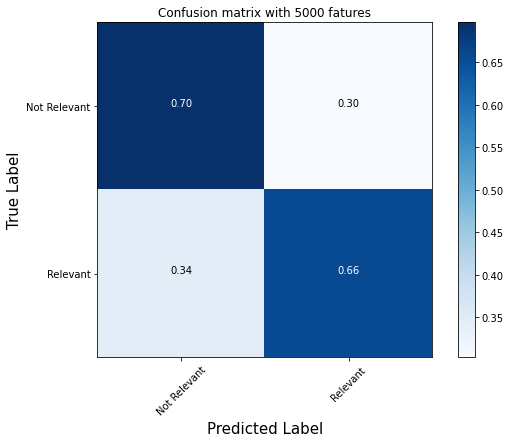

In [57]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
vect = feature_extraction.text.CountVectorizer(preprocessor=data_processing, max_features=5000)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)
nb_model = naive_bayes.MultinomialNB()
nb_model.fit(x_train_dtm, y_train)
y_pred = nb_model.predict(x_test_dtm)

print('Accuracy: ', metrics.accuracy_score(y_test, naive_bayes_predict))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
confusion_mat(cnf_matrix, classes=['Not Relevant', 'Relevant'],
                      normalize=True, title='Confusion matrix with 5000 fatures')

print('ROC AUC Score: ', metrics.roc_auc_score(y_test, naive_bayes_predict))